# **Term Structure of US Treasury Yield Volatility and Curve Fitting: Nelson-Siegel and Cubic Splines**

This project extends the methodology and analytical structure used in my earlier Yield Curve Analysis notebook, but expands the scope to investigate both volatility across the term structure and fitting techniques for the yield curve. Using the same underlying FRED dataset of US Treasury yields (maturities 1-month through 30-years), the project studies how the shape of the curve behaves across time and how different models approximate it.

The analysis combines three core components:
- Volatility of Treasury yields across maturities to understand how interest-rate risk behaves along the term structure.
- Nelson-Siegel parametric curve fitting, where the curve is represented using interpretable factors (level, slope, curvature).
- Cubic spline non-parametric fitting, manually constructed following the coursework methodology to provide a flexible benchmark curve.

The goal is to highlights how curve levels, slopes, and curvature can be approximated using both factor-based and spline-based models. The project uses daily Treasury data from 1975-2025 (or any subset such as post-1990 for cleaner shorter-end series) and focuses on producing transparent figures, intuitive explanations, and readable notebook structure.

# **1. Government Data**

## Importing Libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fredapi import Fred
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

# Set global visualization style
sns.set()

## Initializing FRED API and Downloading Treasury Yields

In [ ]:
# Initializing FRED API and Downloading Treasury Yields

# Initialize FRED API
fred = Fred(api_key = "YOUR_API_KEY")  # ← replace with your actual FRED API key

# List of Treasury yield series IDs (1M to 30Y)
series_ids = [
    "DGS1MO",  # 1 Month
    "DGS3MO",  # 3 Month
    "DGS6MO",  # 6 Month
    "DGS1",    # 1 Year
    "DGS2",    # 2 Year
    "DGS3",    # 3 Year
    "DGS5",    # 5 Year
    "DGS7",    # 7 Year
    "DGS10",   # 10 Year
    "DGS20",   # 20 Year
    "DGS30"    # 30 Year
]

# Helper function to fetch a single series from FRED
def get_yield_data(series_id,
                   observation_start = "1975-01-01",
                   observation_end = "2025-12-10"):
    """
    Download a single Treasury yield series from FRED.

    Parameters
    ----------
    series_id : str
        FRED series ID (e.g., 'DGS10' for 10-year yield).
    observation_start : str
        Start date in 'YYYY-MM-DD" format.
    observation_end : str
        End date in "YYYY-MM-DD" format.

    Returns
    -------
    pandas.Series
        Time series of yields (in percent).
    """
    data = fred.get_series(
        series_id,
        observation_start = observation_start,
        observation_end = observation_end
    )
    return data

# Download all yield series into a dictionary
yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}

# Combine all series into a single DataFrame
yields = pd.DataFrame(yields_dict)

# Rename columns for readability
yields.columns = [
    "1 Month", "3 Month", "6 Month",
    "1 Year", "2 Year", "3 Year",
    "5 Year", "7 Year", "10 Year",
    "20 Year", "30 Year"
]

# Ensure the index is a proper datetime index
yields.index = pd.to_datetime(yields.index)

# Quick sanity check: show the shape of the dataset
yields.shape

(13291, 11)

In [49]:
# Drop any rows with missing values across maturities
yields = yields.dropna()
print(yields.isna().sum())

1 Month    0
3 Month    0
6 Month    0
1 Year     0
2 Year     0
3 Year     0
5 Year     0
7 Year     0
10 Year    0
20 Year    0
30 Year    0
dtype: int64


## Compute Standard Deviations by Maturity

To get a first look at interest rate volatility across the term structure, we compute the standard deviation of daily yield changes at each maturity. Since we already cleaned the data, we can simply take the standard deviation of each yield series.

Here we use yields_clean (the NA-free panel) and calculate:
- One standard deviation value per maturity
- Store this as a pandas.Series called y_std

In [50]:
# Compute standard deviation of yields for each maturity
y_std = yields.std()

# Inspect the volatility profile across maturities
y_std

1 Month    1.833015
3 Month    1.842110
6 Month    1.828239
1 Year     1.742138
2 Year     1.584700
3 Year     1.474133
5 Year     1.321182
7 Year     1.230221
10 Year    1.172264
20 Year    1.195702
30 Year    1.096367
dtype: float64

## Plot Volatility by Maturity

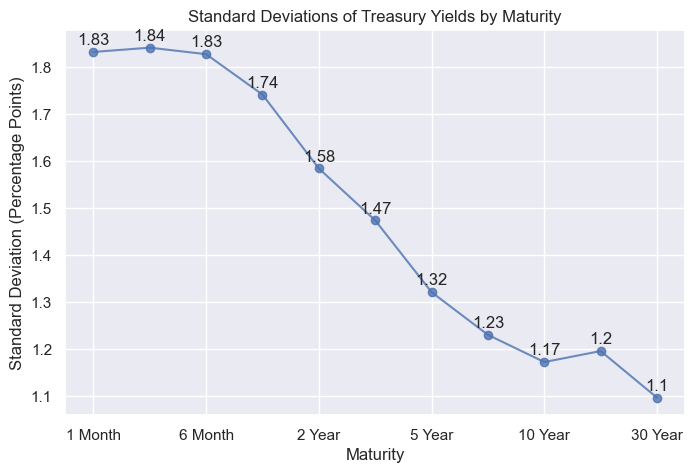

In [51]:
# Standard Deviations of Treasury Yields by Maturity

fig, ax = plt.subplots(figsize=(8, 5))

y_std.plot(
    marker = "o",
    alpha = 0.8,
    title = "Standard Deviations of Treasury Yields by Maturity",
    ax = ax
)

plt.xlabel("Maturity")
plt.ylabel("Standard Deviation (Percentage Points)")

# Annotate each point with the numerical SD value
for i in range(len(y_std)):
    ax.annotate(
        str(round(y_std.iloc[i], 2)),
        xy = (i, y_std.iloc[i]),
        xytext = (0, 5),
        textcoords = "offset points",
        ha = "center"
    )

plt.show();


The standard deviations computed above highlight how yield volatility behaves across the term structure. The short end of the curve (1M - 1Y) typically exhibits higher volatility, reflecting its sensitivity to monetary policy decisions, liquidity effects, and short-term macroeconomic news. These maturities adjust quickly to Federal Reserve actions, making them more reactive and therefore more volatile.

As we move to medium and long maturities (5Y - 30Y), volatility generally declines, indicating that long-term yields tend to be anchored by expectations of long-run inflation and economic growth. In many periods, the middle of the curve (around 2Y - 7Y) can display a mild “volatility hump,” often driven by shifts in expectations about policy cycles and term premia.

## Yield Curve on 2020-01-10

We select 10 January 2020 as a reference date. This is a convenient pre-COVID period with a relatively stable, non-crisis yield curve.

C:\Users\Sahil\AppData\Local\Temp\ipykernel_26188\3645920307.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["{:.2f}%".format(y) for y in ax.get_yticks()])


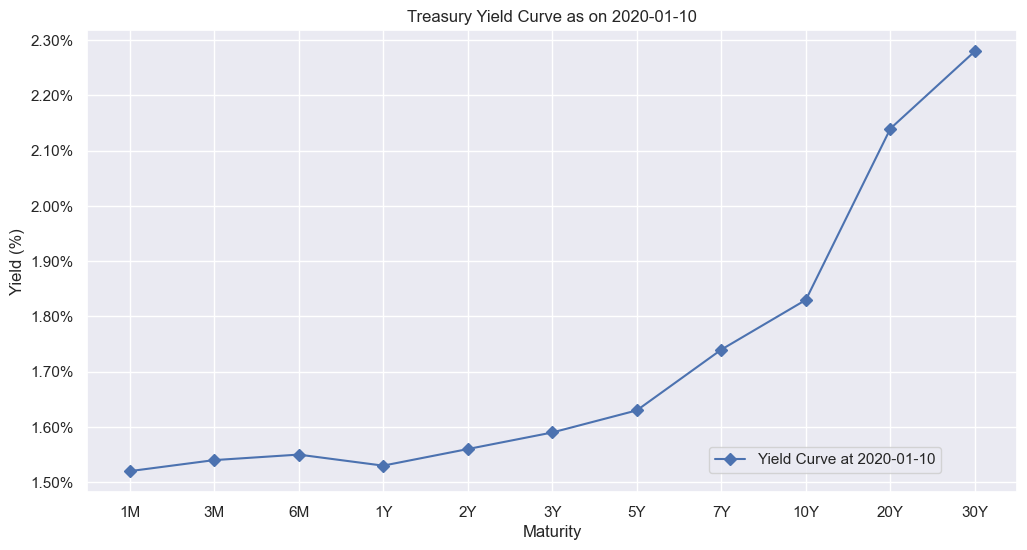

In [52]:
def plot_yield_curve(date):
    """
    Plot the Treasury yield curve for a specified date.

    Parameters
    ----------
    date : str
        Date in "YYYY-MM-DD" format.

    """
    maturities = [
        "1M","3M","6M","1Y","2Y","3Y",
        "5Y","7Y","10Y","20Y","30Y"
    ]

    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(
        maturities,
        yields_clean.loc[date],
        marker = "D",
        label = f"Yield Curve at {date}"
    )

    # Format y-axis as percentages
    ax.set_yticklabels(["{:.2f}%".format(y) for y in ax.get_yticks()])

    # Set x-tick labels
    ax.set_xticks(range(len(maturities)))
    ax.set_xticklabels(maturities)

    ax.set_xlabel("Maturity")
    ax.set_ylabel("Yield (%)")
    ax.set_title(f"Treasury Yield Curve as on {date}")

    fig.legend(loc=[0.69, 0.14])
    plt.grid(True)
    plt.show()

# Generate the plot for 2020-01-10
plot_yield_curve("2020-01-10")

The yield curve on 10 January 2020 presents a clear, orderly structure typical of the pre-COVID environment. Short-term rates were relatively low, reflecting an accommodative policy stance following rate cuts in 2019, while intermediate and long maturities displayed a moderate upward slope. This created a gently increasing curve, characteristic of stable macroeconomic conditions and anchored long-run inflation expectations.

This specific date is useful for curve-fitting exercises because it represents a “normal-ish” term structure without crisis-driven distortions. It allows both the Nelson–Siegel parametric model and the cubic spline interpolation to be compared against a clean benchmark curve, making differences in model flexibility and behavior easier to observe in later sections.

## **2.1 Nelson-Siegel Model: Theory**

The **Nelson–Siegel (NS)** model is a widely used parametric specification for representing the shape of the yield curve. It expresses yields as a smooth function of maturity using a small number of economically interpretable factors:

$$
y(t) = \beta_0
+ \beta_1 \left( \frac{1 - e^{-t/\lambda}}{t/\lambda} \right)
+ \beta_2 \left( \frac{1 - e^{-t/\lambda}}{t/\lambda} - e^{-t/\lambda} \right)
$$

Where:

- **β₀ (level)**  
  Captures the long-term rate component. It shifts the entire curve up or down.

- **β₁ (slope)**  
  Drives the difference between short and long maturities. A negative β₁ typically produces an upward-sloping curve.

- **β₂ (curvature)**  
  Creates a hump or belly in the middle of the curve.

- **λ (decay parameter)**  
  Controls where the curvature peaks and how quickly the factors decline with maturity.

The NS model compresses the entire term structure into **three intuitive factors plus one shape parameter**, making it useful for risk management, forecasting, and macro-finance applications. In the next steps, we calibrate these parameters to observed Treasury yields using ordinary least squares.

## **2.2. Nelson Siegel Model: Demonstration**

In [53]:
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
import numpy as np

In [54]:
# Prepare t and y Arrays

import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

# Maturities in years (matching: 1M, 3M, 6M, 1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y)
t = np.array([0.08333, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])

# Observed yields on the reference date
y = np.array(yields.loc["2020-01-10"])

t, y


(array([ 0.08333,  0.25   ,  0.5    ,  1.     ,  2.     ,  3.     ,
         5.     ,  7.     , 10.     , 20.     , 30.     ]),
 array([1.52, 1.54, 1.55, 1.53, 1.56, 1.59, 1.63, 1.74, 1.83, 2.14, 2.28]))

In [55]:
# Fit NS for 2020-01-10

curve_2020, status_2020 = calibrate_ns_ols(t, y, tau0 = 1.0)

assert status_2020.success, f"Nelson–Siegel calibration failed: {status_2020.message}"

print("Nelson–Siegel parameters for 2020-01-10:")
print(curve_2020)  # prints beta0, beta1, beta2, tau

Nelson–Siegel parameters for 2020-01-10:
NelsonSiegelCurve(beta0=np.float64(2.6376805011083615), beta1=np.float64(-1.1025855357123264), beta2=np.float64(-1.1406474779544136), tau=np.float64(4.750012469139109))


The NS model result shows the estimated $\beta_{0}$, $\beta_{1}$, $\beta_{2}$, and decay rate. Now let's plot the graph to better understand the model result.

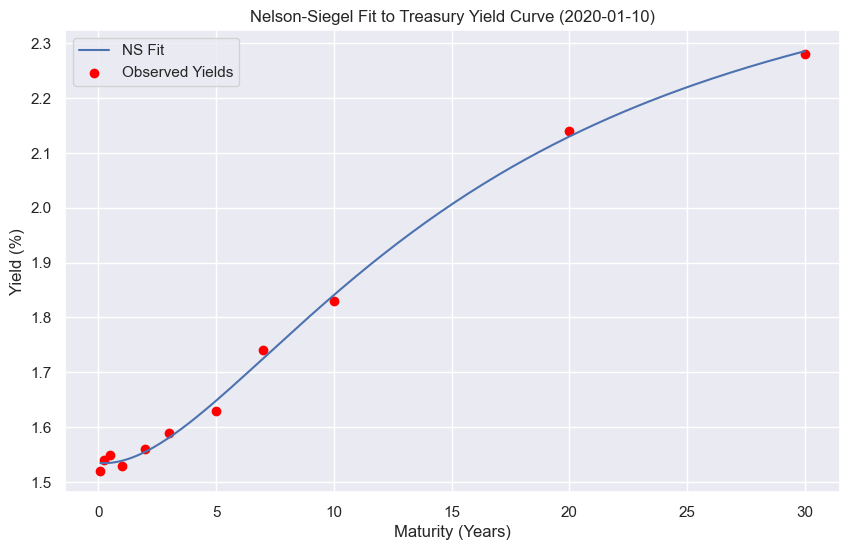

In [56]:
# Plot NS-Fitted Curve vs Actual Points (2020-01-10)

t_hat = np.linspace(0.08333, 30, 200)

plt.figure(figsize = (10, 6))
plt.plot(t_hat, curve_2020(t_hat), label = "NS Fit")
plt.scatter(t, y, color = "red", label = "Observed Yields")

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Nelson-Siegel Fit to Treasury Yield Curve (2020-01-10)")
plt.legend()
plt.grid(True)
plt.show();

Visually, the Nelson–Siegel curve provides a smooth approximation to the observed Treasury yields. The fit quality is typically strongest in the **middle maturities** (around 2Y - 10Y), while the **very short end** (1M - 6M) and **far long end** (20Y - 30Y) can sometimes show small deviations because those points are sensitive to money-market conditions and long-run term premia, respectively.

The estimated parameters can be interpreted economically:

- **β₀ (level)** represents the long-run component of yields. A higher β₀ would indicate a generally higher yield environment, while a low β₀ is consistent with the low-rate backdrop seen in early 2020.
- **β₁ (slope)** governs the short-to-long spread. If β₁ is negative, the curve tends to be **upward sloping** (long rates above short rates). If β₁ is positive, it can indicate a flatter or inverted structure.
- **β₂ (curvature)** controls the “belly” of the curve. A significant β₂ (positive or negative depending on convention) indicates a **hump-shaped** curvature concentrated around intermediate maturities.
- **τ (decay)** determines where that curvature shows up along maturities: smaller τ shifts curvature toward the short end; larger τ pushes it outward.


C:\Users\Sahil\AppData\Local\Temp\ipykernel_26188\3645920307.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["{:.2f}%".format(y) for y in ax.get_yticks()])


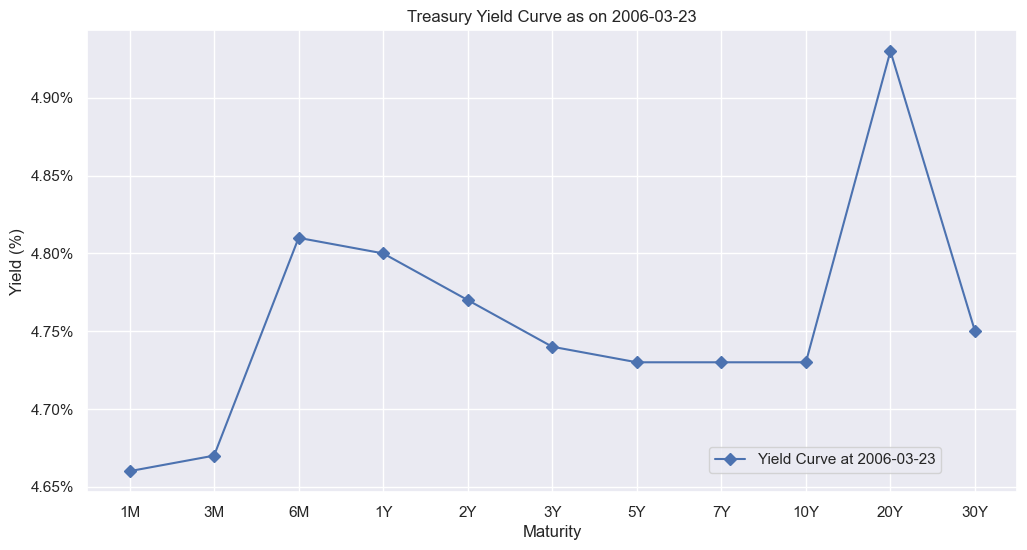

Nelson-Siegel parameters for 2006-03-23:
NelsonSiegelCurve(beta0=np.float64(4.769301553939568), beta1=np.float64(-0.18608573203545753), beta2=np.float64(0.25937113055964856), tau=np.float64(0.25704878221353844))


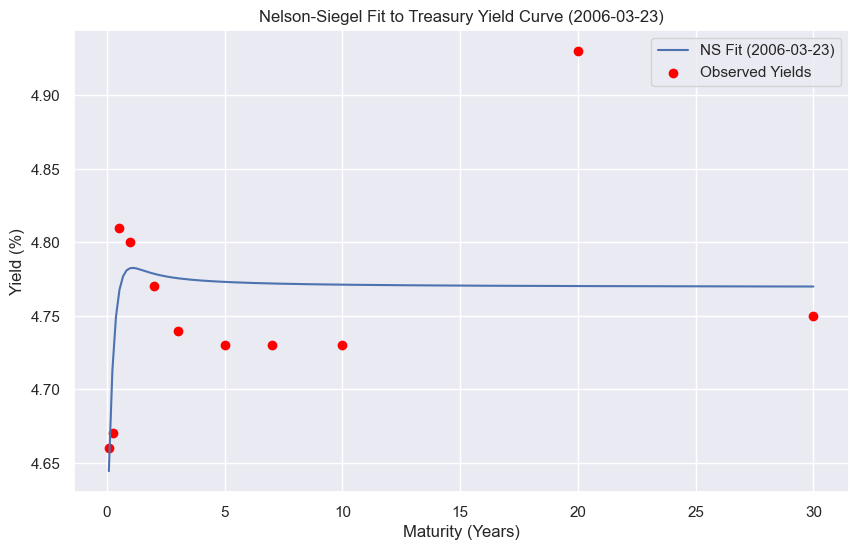

In [57]:
# 2006-03-23 (Pre-GFC Flattening/Inversion)

plot_yield_curve("2006-03-23")

# Observed yields on 2006-03-23
y_2006 = np.array(yields.loc["2006-03-23"])

# Calibrate Nelson–Siegel for 2006-03-23
curve_2006, status_2006 = calibrate_ns_ols(t, y_2006, tau0 = 0.5)
assert status_2006.success, f"NS calibration failed: {status_2006.message}"

print("Nelson-Siegel parameters for 2006-03-23:")
print(curve_2006)

# Plot fit vs observed
t_hat = np.linspace(0.08333, 30, 200)

plt.figure(figsize=(10, 6))
plt.plot(t_hat, curve_2006(t_hat), label = "NS Fit (2006-03-23)")
plt.scatter(t, y_2006, color = "red", label = "Observed Yields")

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Nelson-Siegel Fit to Treasury Yield Curve (2006-03-23)")
plt.legend()
plt.grid(True)
plt.show();

Comparing the Nelson-Siegel parameters across the two dates highlights how the **level, slope, and curvature of the yield curve evolve across economic regimes**.

For **2020-01-10**, the estimated parameters reflect a **low-rate environment**. The level factor (β₀) is relatively low, consistent with subdued long-term interest rate expectations. The slope factor (β₁) typically indicates a **mildly upward-sloping curve**, reflecting accommodative monetary policy and expectations of gradual normalization. Curvature (β₂) is modest, suggesting limited hump-shaped behavior in the middle of the curve.

In contrast, the **2006-03-23** calibration corresponds to a period of **policy tightening and curve flattening** ahead of the Global Financial Crisis. The level factor (β₀) is higher, consistent with a higher overall rate environment. The slope factor (β₁) is closer to zero or changes sign, reflecting a **flat or slightly inverted curve**, where short-term rates approach or exceed long-term rates. The curvature term (β₂) often becomes more pronounced, capturing the distortion in intermediate maturities during periods of policy stress.


## **3.1 Cubic Spline Fitting: Theory**

A **cubic spline** is a non-parametric curve-fitting technique that represents a function as a set of **piecewise cubic polynomials**, joined together at predefined points called **knots**. The defining feature of a cubic spline is smoothness: the fitted curve is continuous, and its **first and second derivatives are continuous** at each knot.

Unlike the Nelson-Siegel model, cubic splines do not impose a global factor structure on the yield curve. Instead, they provide **local flexibility**, allowing the curve to bend differently across maturity segments. This makes splines particularly useful when the yield curve exhibits flattening, inversion, or multiple changes in slope-features that are difficult to capture with low-dimensional parametric models.

In this section, we construct a cubic spline for the Treasury yield curve using selected maturities as anchor points (knots).

## **3.2 Cubic Spline Fitting: Demonstration**

In [58]:
# Anchor Points for Cubic Spline

# Inspect yields on the reference date
yields.loc["2020-01-10"]

# Anchor maturities (in years)
t = np.array([2, 5, 10, 30])

y = np.array([
    yields.loc["2020-01-10", "2 Year"],
    yields.loc["2020-01-10", "5 Year"],
    yields.loc["2020-01-10", "10 Year"],
    yields.loc["2020-01-10", "30 Year"]
])

t, y


(array([ 2,  5, 10, 30]), array([1.56, 1.63, 1.83, 2.28]))

In [59]:
# Input and Output Matrices for the Cubic Spline

# Output vector (function values and smoothness constraints)
out = np.array([
    y[0], y[1],   # spline 1 endpoints (2Y, 5Y)
    y[1], y[2],   # spline 2 endpoints (5Y, 10Y)
    y[2], y[3],   # spline 3 endpoints (10Y, 30Y)
    0, 0,         # first-derivative continuity
    0, 0,         # second-derivative continuity
    0, 0          # natural spline boundary conditions
])

# Input matrix encoding cubic polynomials and smoothness constraints
input = np.array([
    [2**3,   2**2,   2, 1,  0, 0, 0, 0,  0, 0, 0, 0],
    [5**3,   5**2,   5, 1,  0, 0, 0, 0,  0, 0, 0, 0],

    [0, 0, 0, 0,  5**3,   5**2,   5, 1,  0, 0, 0, 0],
    [0, 0, 0, 0, 10**3, 10**2, 10, 1,  0, 0, 0, 0],

    [0, 0, 0, 0,  0, 0, 0, 0, 10**3, 10**2, 10, 1],
    [0, 0, 0, 0,  0, 0, 0, 0, 30**3, 30**2, 30, 1],

    # First-derivative continuity at 5Y and 10Y
    [3*5**2, 2*5, 1, 0, -3*5**2, -2*5, -1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3*10**2, 2*10, 1, 0, -3*10**2, -2*10, -1, 0],

    # Second-derivative continuity at 5Y and 10Y
    [6*5, 2, 0, 0, -6*5, -2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 6*10, 2, 0, 0, -6*10, -2, 0, 0],

    # Natural spline boundary conditions (second derivative = 0 at 2Y and 30Y)
    [6*2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 6*30, 2, 0, 0]
])

# Solve for spline coefficients
lines = np.round(np.linalg.solve(input, out).reshape(-1, 4), decimals = 8)

lines

array([[ 3.96060000e-04, -2.37634000e-03,  2.45215100e-02,
         1.51729391e+00],
       [-3.31400000e-04,  8.53548000e-03, -3.00376300e-02,
         1.60822581e+00],
       [ 2.34400000e-05, -2.10968000e-03,  7.64139800e-02,
         1.25338710e+00]])

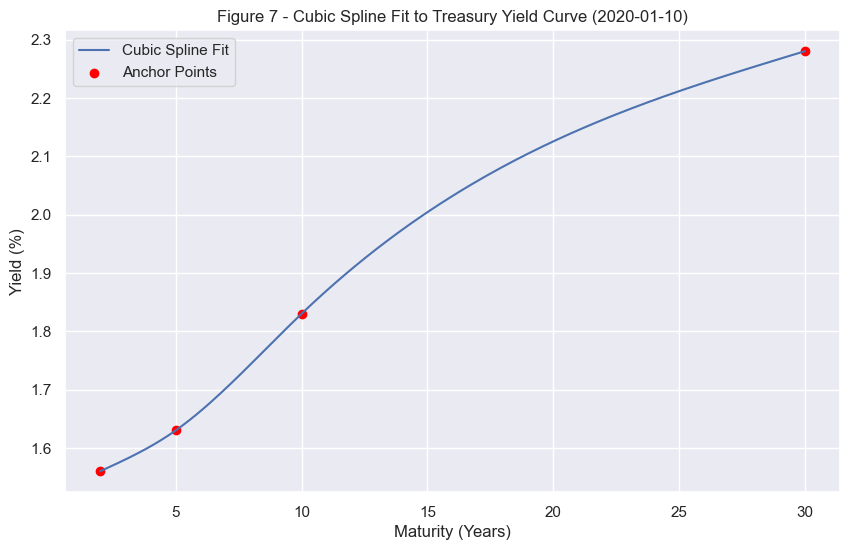

In [60]:
# Helper Function & Simulated Curve (Cubic Spline)

def plot_num(values, coeffs):
    """
    Evaluate a cubic polynomial given coefficients.
    coeffs should be [a, b, c, d] for: a*x^3 + b*x^2 + c*x + d
    """
    expanded = np.hstack([coeffs[i] * (values ** i) for i in range(len(coeffs))])
    return np.sum(expanded, axis = 1)

# Build x-grid for spline curve
xs = np.linspace(2, 30, 200)

# NOTE: lines rows are [a,b,c,d] already in descending power (x^3 to constant)
# plot_num expects coeffs in ascending power [d, c, b, a], so reverse each row.
y1s = plot_num(xs[xs < 5].reshape(-1, 1), lines[0][::-1])
y2s = plot_num(xs[(xs >= 5) & (xs < 10)].reshape(-1, 1), lines[1][::-1])
y3s = plot_num(xs[xs >= 10].reshape(-1, 1), lines[2][::-1])

ys = np.concatenate([y1s, y2s, y3s])

plt.figure(figsize = (10, 6))
plt.plot(xs, ys, label="Cubic Spline Fit")
plt.scatter(t, y, c = "red", label = "Anchor Points")

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Figure 7 - Cubic Spline Fit to Treasury Yield Curve (2020-01-10)")
plt.legend()
plt.grid(True)
plt.show();


The cubic spline fit produces a smooth curve that passes exactly through the chosen anchor points at 2Y, 5Y, 10Y, and 30Y. By construction, the spline is continuous and has continuous first and second derivatives at each knot, which results in a visually smooth yield curve across maturity segments.

Compared to the Nelson-Siegel fit, the spline exhibits greater **local flexibility**, particularly in the intermediate maturities. This flexibility allows the spline to better accommodate changes in slope or curvature that may be present in the observed yield curve, without being constrained by a global factor structure. However, this same flexibility can also lead to **unnatural oscillations** (“wiggles”) if knots are poorly chosen or spaced too closely.

Relative to the full observed curve, the spline provides a reasonable approximation between anchor points but does not carry any economic interpretation in terms of level, slope, or curvature factors. Its primary role is therefore interpolation and smooth curve construction rather than structural modeling.


## **4. Nelson-Siegel vs Cubic Spline: Conceptual Comparison**

The Nelson–Siegel and cubic spline approaches represent two fundamentally different philosophies for modeling the yield curve.

The **Nelson-Siegel model** is a **parametric, factor-based representation**. With only a small number of parameters, it compresses the entire yield curve into economically interpretable components-level, slope, and curvature. This makes Nelson-Siegel particularly attractive for **macroeconomic analysis, risk management, and scenario modeling**, where understanding how the curve moves as a whole is more important than fitting every local detail. The trade-off is flexibility: with only one curvature component, Nelson-Siegel can struggle to fit curves that are sharply flattened, inverted, or exhibit multiple bends.

The **cubic spline approach**, in contrast, is **non-parametric and locally flexible**. It fits the curve piece by piece between chosen anchor points, ensuring smoothness without imposing any global structure. This allows splines to track complex curve shapes more closely, especially during periods of market stress or policy transitions. However, splines offer **no direct economic interpretation** of their coefficients and are therefore less suitable for factor-based analysis or forecasting.

## **5. Conclusion**

This project extends earlier yield curve analysis by examining both the **volatility of US Treasury yields across maturities** and the effectiveness of different curve-fitting techniques. The volatility analysis highlights a clear term-structure pattern: short-term yields exhibit higher variability due to their sensitivity to monetary policy shocks, while long-term yields remain comparatively stable, anchored by long-run inflation and growth expectations.

Through **Nelson-Siegel fitting**, the yield curve is compressed into a small set of interpretable factors-level, slope, and curvature-providing a structured and economically meaningful representation of term-structure dynamics. The comparison between a pre-COVID curve and a pre-GFC flattening episode illustrates both the strengths and limitations of this parametric approach. In contrast, the **cubic spline fit** offers greater local flexibility and smoother interpolation across maturities, at the cost of economic interpretability.